In [ ]:
import os
import random
import time
import copy
import itertools
from collections import defaultdict
import hashlib
from matplotlib.backends.backend_pdf import PdfPages
import sys

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from scipy.ndimage import gaussian_filter
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

from lime import lime_image
from skimage.segmentation import slic
from skimage.transform import resize

from captum.attr import IntegratedGradients, LayerGradCam
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
# DEFINE MODE
# 0 = load trained models
# 1 = train models with certain hyperparameters
# 2 = hpo
mode = 0

In [4]:
# define directories and devices
IMAGE_DIR = "images/train_images"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
# set random seed
seed = 42
generator = torch.Generator().manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
## ---->DATA PREPROCESSING AND DEFINITIONS<----

In [7]:
# define transforms
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
# import dataset
class PaddyDiseaseDataset(Dataset):
    def __init__(self, image_dir, transform=None, label_map=None, image_files=None):
        self.image_dir = image_dir
        self.transform = transform

        if image_files is not None:
            self.image_files = image_files
            self.label_to_index = label_map
        else:
            self.image_files = []
            self.label_to_index = {} if label_map is None else label_map.copy()
            for disease_name in sorted(os.listdir(image_dir)):
                disease_path = os.path.join(image_dir, disease_name)
                if os.path.isdir(disease_path):
                    if disease_name not in self.label_to_index:
                        self.label_to_index[disease_name] = len(self.label_to_index)
                    for img_file in os.listdir(disease_path):
                        img_path = os.path.join(disease_path, img_file)
                        if os.path.isfile(img_path):
                            self.image_files.append((img_path, disease_name))
            random.shuffle(self.image_files)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        while True:
            img_path, disease_label = self.image_files[idx]
            if not os.path.exists(img_path):
                print(f"Warning: Missing file {img_path}, skipping...")
                idx = (idx + 1) % len(self.image_files)
                continue
            try:
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                label = self.label_to_index[disease_label]
                return image, label
            except Exception as e:
                print(f"Error loading {img_path}: {e}, skipping...")
                idx = (idx + 1) % len(self.image_files)

In [9]:
# load dataset
full_dataset = PaddyDiseaseDataset(IMAGE_DIR, transform=original_transform)
label_map = full_dataset.label_to_index
total_size = len(full_dataset)
num_classes = len(label_map)
print(f"Total Images: {total_size}")
print(f"Number of Classes: {len(label_map)}")

# print count in each class
class_counts = {}
for _, lbl in full_dataset.image_files:
    class_counts[lbl] = class_counts.get(lbl, 0) + 1
for cls, cnt in class_counts.items():
    print(f"- {cls}: {cnt} images")

Total Images: 10407
Number of Classes: 10
- brown_spot: 965 images
- dead_heart: 1442 images
- tungro: 1088 images
- hispa: 1594 images
- normal: 1764 images
- blast: 1738 images
- bacterial_leaf_blight: 479 images
- bacterial_panicle_blight: 337 images
- bacterial_leaf_streak: 380 images
- downy_mildew: 620 images


In [10]:
# split data into ~80 - ~10 - 10 for non-augmented train/val and test
test_size = int(0.10 * total_size)
train_val_size = total_size - test_size
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size], generator=generator)
train_size = int(0.85 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_no_aug, val_no_aug = random_split(train_val_dataset, [train_size, val_size], generator=generator)


print(f"Train count: {len(train_no_aug)}")
print(f"Val count: {len(val_no_aug)}")
print(f"Test count: {len(test_dataset)}")

Train count: 7961
Val count: 1406
Test count: 1040


In [11]:
# augment data
def extract_files(subset, full_ds):
    return [full_ds.image_files[i] for i in subset.indices]

train_files = extract_files(train_no_aug, full_dataset)
val_files   = extract_files(val_no_aug, full_dataset)

train_aug = PaddyDiseaseDataset(IMAGE_DIR, transform=aug_transform, label_map=label_map, image_files=train_files)
val_aug   = PaddyDiseaseDataset(IMAGE_DIR, transform=aug_transform, label_map=label_map, image_files=val_files)

print(f"Augmented train count: {len(train_aug)}")
print(f"Augmented val count: {len(val_aug)}")

Augmented train count: 7961
Augmented val count: 1406


In [12]:
# create dataloaders 
train_no_aug_loader = DataLoader(train_no_aug, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)
val_no_aug_loader   = DataLoader(val_no_aug, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)

train_aug_loader = DataLoader(train_aug, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)
val_aug_loader   = DataLoader(val_aug, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Displaying 10 sample training images (non-augmented):


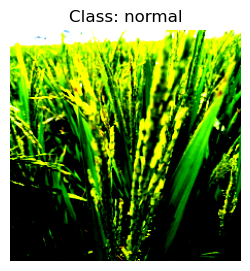

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


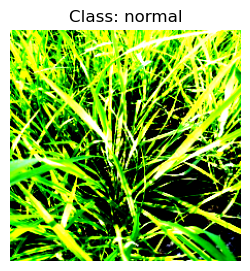

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


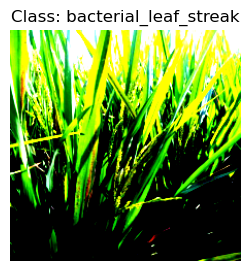

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


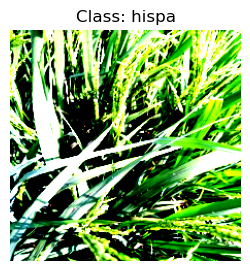

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


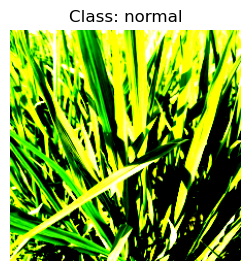

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


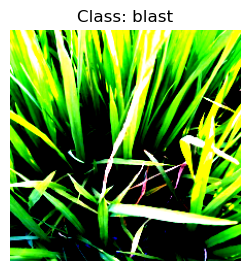

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


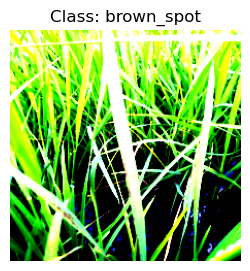

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


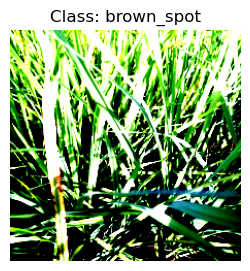

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


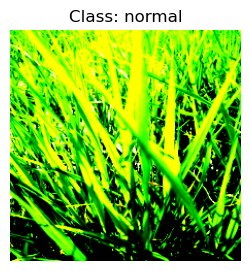

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


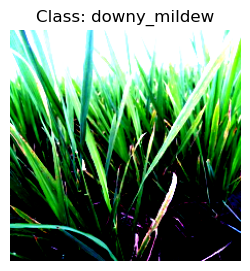

In [ ]:
# display samples
print("\nDisplaying 10 sample training images (non-augmented):")
for i in range(10):
    sample = train_no_aug[i]
    if len(sample) == 2:
        image, label = sample
    else:
        image, label, aug = sample
    plt.figure(figsize=(3, 3))
    plt.imshow(image.permute(1, 2, 0))
    class_name = list(label_map.keys())[list(label_map.values()).index(label)]
    plt.title(f"Class: {class_name}")
    plt.axis("off")
    plt.show()

In [14]:
## ---->DEFINE MODEL AND HPO<----

In [15]:
# define model
class PaddyCNN(nn.Module):
    def __init__(self, num_classes, num_filters, dropout_rate):
        super(PaddyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters[0], kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters[0])
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters[1])
        self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_filters[2])
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout_conv = nn.Dropout2d(dropout_rate * 0.5)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.flattened_size = num_filters[2] * 4 * 4
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)
        x = self.adaptive_pool(x)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [16]:
# train model with defined hyperparameters
def train_model(model, train_loader, val_loader, optimizer, criterion, scaler, device, num_epochs=100):
    model.to(device)
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / total_train
        train_acc = 100 * correct_train / total_train

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / total_val
        val_acc = 100 * correct_val / total_val
        f1 = f1_score(all_labels, all_preds, average="weighted")

        if f1 > best_f1:
            best_f1 = f1
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {avg_val_loss:.4f}, Val Acc:   {val_acc:.2f}%, Val F1: {f1:.4f}")

    model.load_state_dict(best_model_wts)
    return model

In [17]:
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return avg_loss, accuracy, f1

In [18]:
# hyperparameters to test
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64]
num_filters_options = [[64, 128, 256], [32, 64, 128]]
dropout_rates = [0.2, 0.3, 0.4]


hyperparameter_grid = list(itertools.product(learning_rates, batch_sizes, num_filters_options, dropout_rates))

best_f1 = 0
best_hyperparams = {}
best_model_hpo = None

# do hpo
if mode == 2:
    total_start = time.time()

    for idx, (lr, batch_size, num_filters, dropout) in enumerate(hyperparameter_grid):
        combo_start = time.time()
        print(f"\n[{idx+1}/{len(hyperparameter_grid)}] LR={lr}, Batch={batch_size}, Filters={num_filters}, Dropout={dropout}", flush=True)
        
        model_hpo = PaddyCNN(num_classes, num_filters, dropout)
        if torch.cuda.device_count() > 1:
            model_hpo = nn.DataParallel(model_hpo)
        model_hpo = model_hpo.to(device)
        
        criterion_hpo = nn.CrossEntropyLoss().to(device)
        optimizer_hpo = optim.Adam(model_hpo.parameters(), lr=lr)
        scaler_hpo = torch.cuda.amp.GradScaler()

        hpo_train_loader = DataLoader(train_no_aug, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
        hpo_val_loader = DataLoader(val_no_aug, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
        
        for epoch in range(10): # test 10 epochs
            model_hpo.train()
            for images, labels in hpo_train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer_hpo.zero_grad()
                with torch.cuda.amp.autocast():
                    outputs = model_hpo(images)
                    loss = criterion_hpo(outputs, labels)
                scaler_hpo.scale(loss).backward()
                scaler_hpo.step(optimizer_hpo)
                scaler_hpo.update()

        val_loss, val_acc, f1_val = evaluate_model(model_hpo, hpo_val_loader, criterion_hpo)
        combo_time = time.time() - combo_start

        print(f"Validation Results - F1: {f1_val:.4f}, Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")
        print(f"Time: {combo_time:.2f} seconds", flush=True)

        if f1_val > best_f1:
            best_f1 = f1_val
            best_hyperparams = {
                "learning_rate": lr,
                "batch_size": batch_size,
                "num_filters": num_filters,
                "dropout_rate": dropout
            }
            best_model_hpo = model_hpo.module if isinstance(model_hpo, nn.DataParallel) else model_hpo
            torch.save(best_model_hpo.state_dict(), "best_model_hpo.pt")
            print(">> New best model saved to best_model_hpo.pt", flush=True)

    print("\nHPO complete!")
    print(f"Best F1-Score: {best_f1:.4f}")
    print("Best Hyperparameters:", best_hyperparams)
    print(f"Total HPO Time: {time.time() - total_start:.2f} seconds", flush=True)

In [19]:
## ---->TRAIN AND TEST MODEL W/ BEST HYPERPARAMETERS (NON-AUGMENTED DATA)<----

In [20]:
# set best hyperparameters
if mode == 2:
    learning_rate_final = best_hyperparams["learning_rate"]
    batch_size_final = best_hyperparams["batch_size"]
    num_filters_final = best_hyperparams["num_filters"]
    dropout_rate_final = best_hyperparams["dropout_rate"]
    num_epochs_final_no_aug=120 # test amount
    num_epochs_final_aug=120 # test amount
    num_classes = len(label_map)

    train_no_aug_loader = DataLoader(train_no_aug, batch_size=batch_size_final, shuffle=True, num_workers=1, pin_memory=True)
    val_no_aug_loader = DataLoader(val_no_aug, batch_size=batch_size_final, shuffle=False, num_workers=1, pin_memory=True)
    train_aug_loader = DataLoader(train_aug, batch_size=batch_size_final, shuffle=True, num_workers=1, pin_memory=True)
    val_aug_loader = DataLoader(val_aug, batch_size=batch_size_final, shuffle=False, num_workers=1, pin_memory=True)

elif mode == 0 or mode == 1:
    learning_rate_final = 0.0005 # hpo
    batch_size_final = 32 # hpo
    num_filters_final = [64, 128, 256] # hpo
    dropout_rate_final = 0.2 # hpo
    num_epochs_final_no_aug=60  # manually determined using loss chart
    num_epochs_final_aug=105 # manually determined using loss chart
    num_classes = len(label_map)

In [21]:
# train new model with more epochs and set hyperparameters
def final_training(model, train_loader, val_loader, num_epochs, criterion, optimizer, scaler):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / total_train
        train_acc = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / total_val
        val_acc = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%", flush=True)

    return model, train_losses, train_accs, val_losses, val_accs

/opt/ohpc/pub/spack/v0.21.1/opt/spack/linux-rocky8-x86_64_v3/gcc-8.5.0/py-torch-2.1.0-rvl2yjqjwnn7ahi4g6flzxyv2i3xfrsq/lib/python3.10/site-packages/torch/cuda/nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")


Epoch 1 - Train Loss: 1.7965, Train Acc: 38.42%, Val Loss: 1.4131, Val Acc: 51.42%
Epoch 2 - Train Loss: 1.3689, Train Acc: 53.37%, Val Loss: 1.1019, Val Acc: 63.80%
Epoch 3 - Train Loss: 1.1496, Train Acc: 61.66%, Val Loss: 0.8970, Val Acc: 72.12%
Epoch 4 - Train Loss: 0.9966, Train Acc: 67.32%, Val Loss: 0.7871, Val Acc: 77.17%
Epoch 5 - Train Loss: 0.8775, Train Acc: 71.75%, Val Loss: 0.7002, Val Acc: 78.38%
Epoch 6 - Train Loss: 0.7982, Train Acc: 74.11%, Val Loss: 0.5968, Val Acc: 82.15%
Epoch 7 - Train Loss: 0.7091, Train Acc: 76.59%, Val Loss: 0.5778, Val Acc: 81.72%
Epoch 8 - Train Loss: 0.6408, Train Acc: 79.49%, Val Loss: 0.4660, Val Acc: 84.92%
Epoch 9 - Train Loss: 0.6039, Train Acc: 80.78%, Val Loss: 0.4724, Val Acc: 84.92%
Epoch 10 - Train Loss: 0.5541, Train Acc: 82.08%, Val Loss: 0.4419, Val Acc: 85.35%
Epoch 11 - Train Loss: 0.5149, Train Acc: 83.78%, Val Loss: 0.4205, Val Acc: 87.41%
Epoch 12 - Train Loss: 0.4675, Train Acc: 85.29%, Val Loss: 0.3656, Val Acc: 88.76%
E

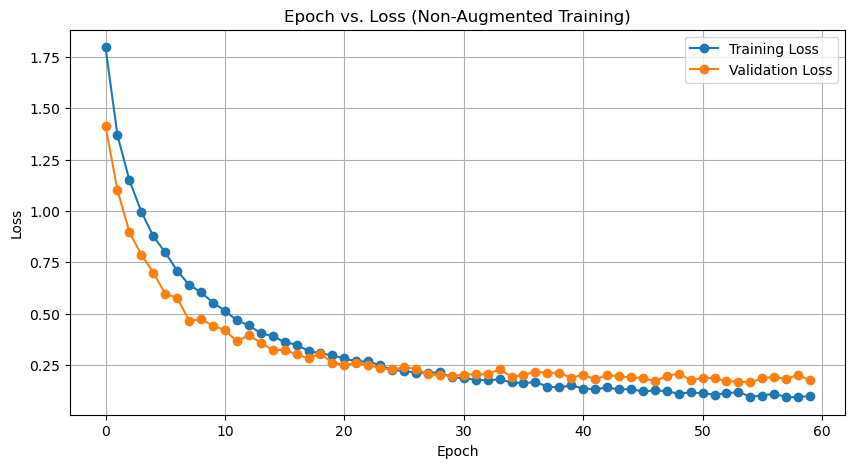

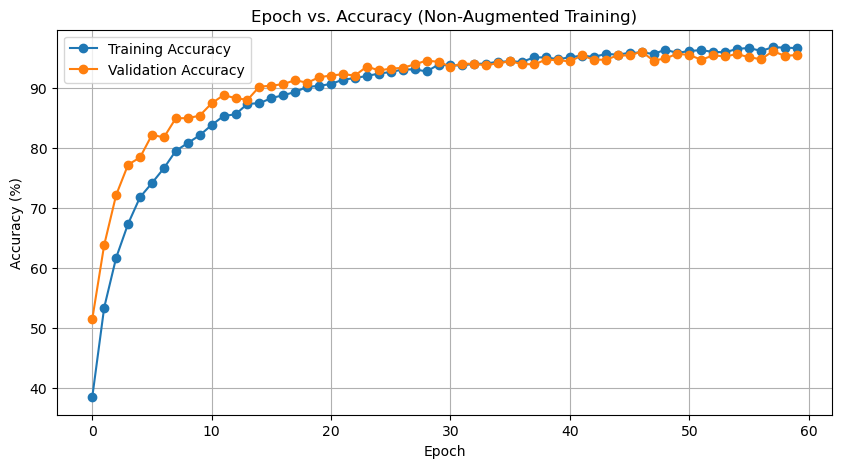

In [22]:
# train with non-augmented data
if mode == 1 or mode == 2:
    final_train_loader = train_no_aug_loader
    final_val_loader   = val_no_aug_loader

    model_final_no_aug = PaddyCNN(num_classes, num_filters_final, dropout_rate_final)
    if torch.cuda.device_count() > 1:
        model_final_no_aug = nn.DataParallel(model_final_no_aug)
    model_final_no_aug = model_final_no_aug.to(device)

    criterion_final = nn.CrossEntropyLoss().to(device)
    optimizer_final = optim.Adam(model_final_no_aug.parameters(), lr=learning_rate_final)
    scaler_final = amp.GradScaler()

    start_time_no_aug = time.time()
    model_final_no_aug, train_losses, train_accs, val_losses, val_accs = final_training(
        model_final_no_aug,
        final_train_loader,
        final_val_loader,
        num_epochs_final_no_aug,
        criterion_final,
        optimizer_final,
        scaler_final
    )
    total_time_no_aug = time.time() - start_time_no_aug
    print(f"\nTotal non-augmented training time: {total_time_no_aug:.2f} seconds", flush=True)

    # save the non-augmented model
    torch.save(model_final_no_aug.module.state_dict() if isinstance(model_final_no_aug, nn.DataParallel) 
            else model_final_no_aug.state_dict(), "model_final_no_aug.pth")
    print("Non-augmented model saved as 'model_final_no_aug.pth'", flush=True)

    # plot the loss and accuracy vs. epochs:
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, 'o-', label="Training Loss")
    plt.plot(val_losses, 'o-', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch vs. Loss (Non-Augmented Training)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(train_accs, 'o-', label="Training Accuracy")
    plt.plot(val_accs, 'o-', label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Epoch vs. Accuracy (Non-Augmented Training)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
# load model
if mode == 0:
    state_dict = torch.load("model_final_no_aug.pth", map_location=device)

    if list(state_dict.keys())[0].startswith("module."):
        new_state_dict = state_dict
    else:
        new_state_dict = {"module." + k: v for k, v in state_dict.items()}

    model_final_no_aug = nn.DataParallel(PaddyCNN(
            num_classes=num_classes,
            num_filters=num_filters_final,
            dropout_rate=dropout_rate_final
        ))
    model_final_no_aug.load_state_dict(new_state_dict)
    model_final_no_aug.to(device)
    model_final_no_aug.eval()


[Final Model, Non-Augmented] Overall Test Loss: 0.1812
[Final Model, Non-Augmented] Overall Test Accuracy: 95.67%

[Final Model, Non-Augmented] Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.83      1.00      0.91        40
   bacterial_leaf_streak       0.98      0.94      0.96        47
bacterial_panicle_blight       0.97      1.00      0.99        35
                   blast       0.97      0.97      0.97       192
              brown_spot       0.94      0.96      0.95        97
              dead_heart       0.98      0.98      0.98       127
            downy_mildew       0.97      0.88      0.92        72
                   hispa       0.94      0.98      0.96       151
                  normal       0.99      0.94      0.96       177
                  tungro       0.92      0.94      0.93       102

                accuracy                           0.96      1040
               macro avg       0.95   

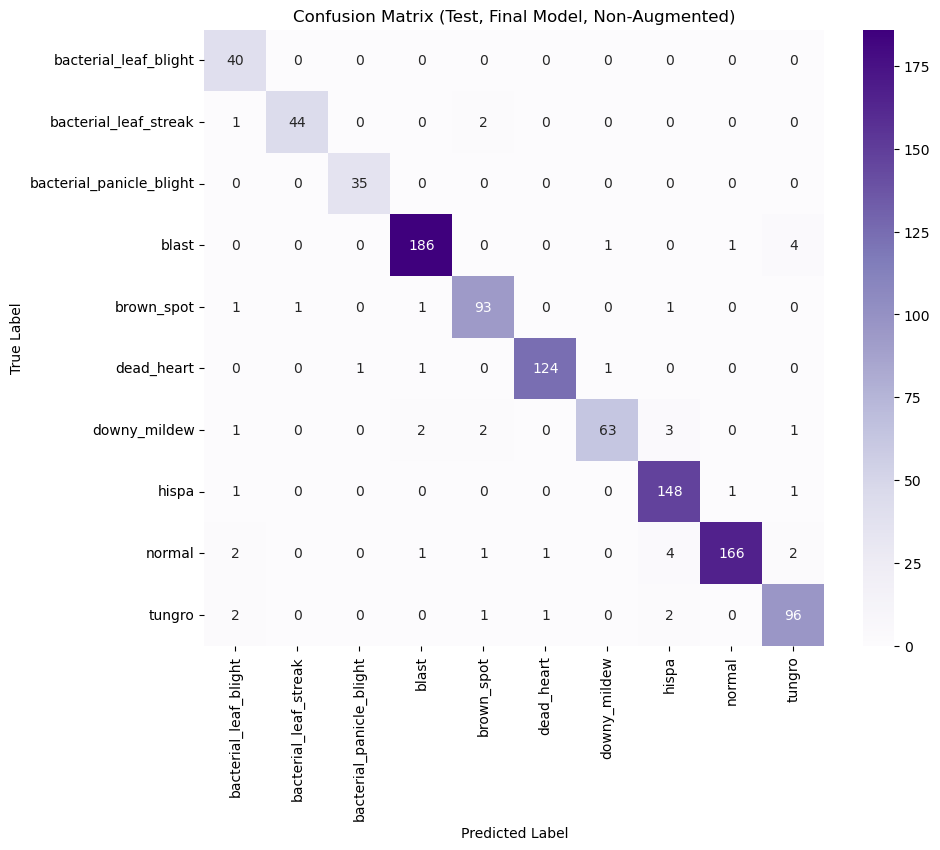

In [24]:
# test non-augmented data
model_final_no_aug.eval()
criterion_final = nn.CrossEntropyLoss().to(device)
overall_test_loss = 0.0
correct_test, total_test = 0, 0
all_test_preds, all_test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_final_no_aug(images)
        overall_test_loss += criterion_final(outputs, labels).item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
avg_test_loss = overall_test_loss / total_test
test_acc = 100 * correct_test / total_test
print(f"\n[Final Model, Non-Augmented] Overall Test Loss: {avg_test_loss:.4f}")
print(f"[Final Model, Non-Augmented] Overall Test Accuracy: {test_acc:.2f}%")
print("\n[Final Model, Non-Augmented] Classification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=list(label_map.keys()), zero_division=0))
cm_overall = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_overall, annot=True, fmt="d", cmap="Purples",
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test, Final Model, Non-Augmented)")
plt.show()


In [25]:
# per-class stats
labels = list(label_map.keys())
cm = confusion_matrix(all_test_labels, all_test_preds)
class_stats = []

for i, label in enumerate(labels):
    total = cm[i].sum()
    correct = cm[i, i]
    incorrect = total - correct
    acc = 100 * correct / total if total > 0 else 0
    class_stats.append({
        "label": label,
        "correct": correct,
        "incorrect": incorrect,
        "total": total,
        "accuracy": acc
    })

class_stats_sorted = sorted(class_stats, key=lambda x: x["accuracy"], reverse=True)

print(f"\n{'Class':<30} {'Correct':>8} {'Incorrect':>10} {'Total':>8} {'Accuracy (%)':>15}")
print("-" * 75)

for stat in class_stats_sorted:
    print(f"{stat['label']:<30} {stat['correct']:>8} {stat['incorrect']:>10} {stat['total']:>8} {stat['accuracy']:>15.2f}")


Class                           Correct  Incorrect    Total    Accuracy (%)
---------------------------------------------------------------------------
bacterial_leaf_blight                40          0       40          100.00
bacterial_panicle_blight             35          0       35          100.00
hispa                               148          3      151           98.01
dead_heart                          124          3      127           97.64
blast                               186          6      192           96.88
brown_spot                           93          4       97           95.88
tungro                               96          6      102           94.12
normal                              166         11      177           93.79
bacterial_leaf_streak                44          3       47           93.62
downy_mildew                         63          9       72           87.50


In [26]:
## ---->TRAIN AND TEST MODEL W/ BEST HYPERPARAMETERS (AUGMENTED DATA)<----

/opt/ohpc/pub/spack/v0.21.1/opt/spack/linux-rocky8-x86_64_v3/gcc-8.5.0/py-torch-2.1.0-rvl2yjqjwnn7ahi4g6flzxyv2i3xfrsq/lib/python3.10/site-packages/torch/cuda/nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")


Epoch 1 - Train Loss: 1.9348, Train Acc: 32.14%, Val Loss: 1.6735, Val Acc: 42.25%
Epoch 2 - Train Loss: 1.6479, Train Acc: 42.32%, Val Loss: 1.4946, Val Acc: 48.86%
Epoch 3 - Train Loss: 1.4848, Train Acc: 48.74%, Val Loss: 1.3458, Val Acc: 53.70%
Epoch 4 - Train Loss: 1.3890, Train Acc: 52.54%, Val Loss: 1.2137, Val Acc: 58.82%
Epoch 5 - Train Loss: 1.3015, Train Acc: 55.96%, Val Loss: 1.1474, Val Acc: 62.66%
Epoch 6 - Train Loss: 1.2242, Train Acc: 58.10%, Val Loss: 1.0722, Val Acc: 63.80%
Epoch 7 - Train Loss: 1.1701, Train Acc: 60.44%, Val Loss: 1.0450, Val Acc: 66.00%
Epoch 8 - Train Loss: 1.1120, Train Acc: 62.58%, Val Loss: 0.9470, Val Acc: 69.91%
Epoch 9 - Train Loss: 1.0705, Train Acc: 64.44%, Val Loss: 0.9023, Val Acc: 71.98%
Epoch 10 - Train Loss: 1.0287, Train Acc: 65.29%, Val Loss: 0.9053, Val Acc: 70.34%
Epoch 11 - Train Loss: 0.9942, Train Acc: 66.15%, Val Loss: 0.8646, Val Acc: 71.91%
Epoch 12 - Train Loss: 0.9824, Train Acc: 67.16%, Val Loss: 0.8282, Val Acc: 73.61%
E

Epoch 99 - Train Loss: 0.2359, Train Acc: 91.86%, Val Loss: 0.2202, Val Acc: 93.81%
Epoch 100 - Train Loss: 0.2231, Train Acc: 92.34%, Val Loss: 0.2210, Val Acc: 94.03%
Epoch 101 - Train Loss: 0.2189, Train Acc: 92.58%, Val Loss: 0.2195, Val Acc: 94.17%
Epoch 102 - Train Loss: 0.2244, Train Acc: 92.46%, Val Loss: 0.2005, Val Acc: 94.38%
Epoch 103 - Train Loss: 0.2281, Train Acc: 92.17%, Val Loss: 0.2353, Val Acc: 93.46%
Epoch 104 - Train Loss: 0.2305, Train Acc: 92.27%, Val Loss: 0.2294, Val Acc: 93.95%
Epoch 105 - Train Loss: 0.2278, Train Acc: 92.25%, Val Loss: 0.2207, Val Acc: 94.10%

Total augmented training time: 8669.30 seconds
Augmented model saved as 'model_final_aug.pth'


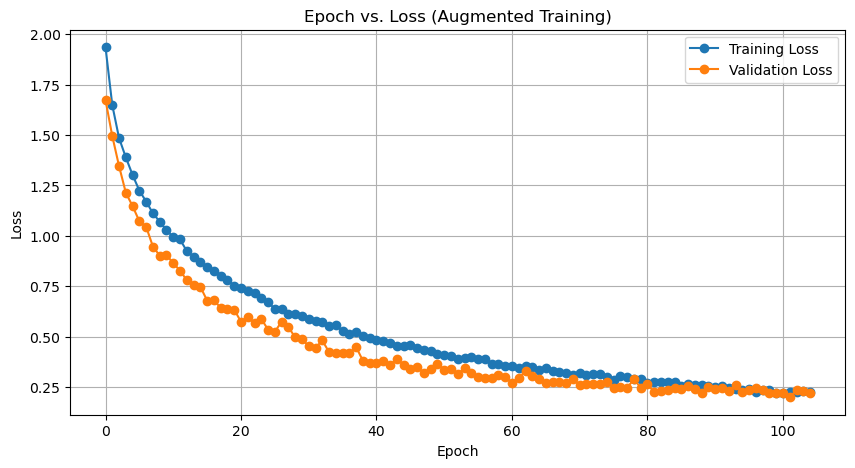

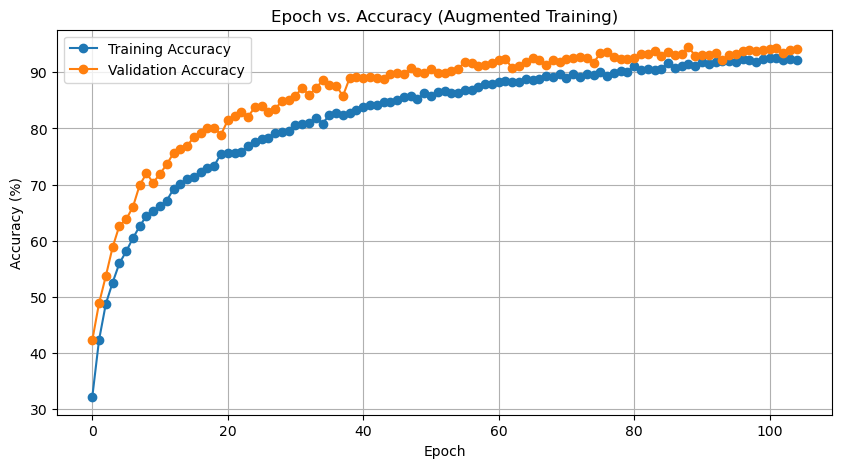

In [ ]:
# train with augmented data
if mode == 1 or mode == 2:
    final_train_loader = train_aug_loader
    final_val_loader   = val_aug_loader

    model_final_aug = PaddyCNN(num_classes, num_filters_final, dropout_rate_final)
    if torch.cuda.device_count() > 1:
        model_final_aug = nn.DataParallel(model_final_aug)
    model_final_aug = model_final_aug.to(device)

    criterion_final = nn.CrossEntropyLoss().to(device)
    optimizer_final = optim.Adam(model_final_aug.parameters(), lr=learning_rate_final)
    scaler_final = amp.GradScaler()

    start_time_aug = time.time()
    model_final_aug, train_losses, train_accs, val_losses, val_accs = final_training(
        model_final_aug,
        final_train_loader,
        final_val_loader,
        num_epochs_final_aug,
        criterion_final,
        optimizer_final,
        scaler_final
    )
    total_time_aug = time.time() - start_time_aug
    print(f"\nTotal augmented training time: {total_time_aug:.2f} seconds", flush=True)

    # save the augmented model
    torch.save(model_final_aug.module.state_dict() if isinstance(model_final_aug, nn.DataParallel) 
            else model_final_aug.state_dict(), "model_final_aug.pth")
    print("Augmented model saved as 'model_final_aug.pth'", flush=True)

    # plot loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, 'o-', label="Training Loss")
    plt.plot(val_losses, 'o-', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch vs. Loss (Augmented Training)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot accuracy
    plt.figure(figsize=(10,5))
    plt.plot(train_accs, 'o-', label="Training Accuracy")
    plt.plot(val_accs, 'o-', label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Epoch vs. Accuracy (Non-augmented Training)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [28]:
# load model
if mode == 0:
    state_dict = torch.load("model_final_aug.pth", map_location=device)

    if list(state_dict.keys())[0].startswith("module."):
        new_state_dict = state_dict
    else:
        new_state_dict = {"module." + k: v for k, v in state_dict.items()}

    model_final_aug = nn.DataParallel(PaddyCNN(
            num_classes=num_classes,
            num_filters=num_filters_final,
            dropout_rate=dropout_rate_final
        ))
    model_final_aug.load_state_dict(new_state_dict)
    model_final_aug.to(device)
    model_final_aug.eval()


[Final Model, Augmented] Overall Test Loss: 0.0639
[Final Model, Augmented] Overall Test Accuracy: 98.46%

[Final Model, Augmented] Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.98      1.00      0.99        40
   bacterial_leaf_streak       0.98      0.98      0.98        47
bacterial_panicle_blight       1.00      0.97      0.99        35
                   blast       0.98      0.99      0.99       192
              brown_spot       0.99      0.99      0.99        97
              dead_heart       0.99      1.00      1.00       127
            downy_mildew       0.97      0.94      0.96        72
                   hispa       0.99      0.97      0.98       151
                  normal       0.99      0.98      0.98       177
                  tungro       0.97      1.00      0.99       102

                accuracy                           0.98      1040
               macro avg       0.98      0.98     

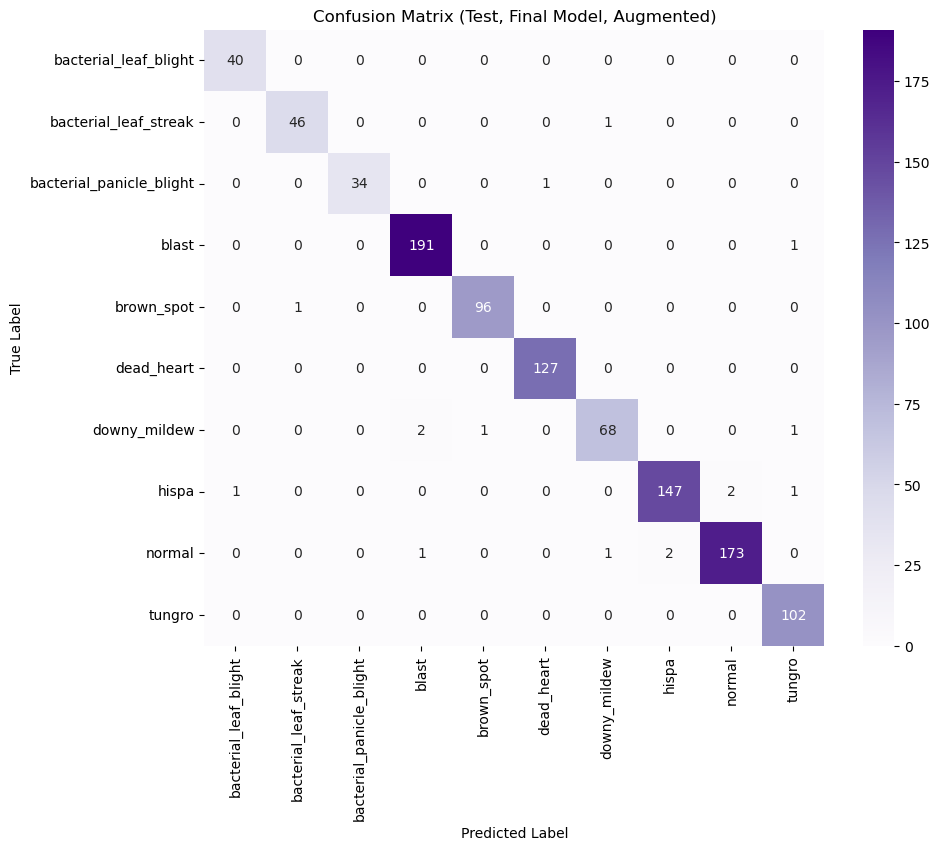

In [29]:
# test augmented data
model_final_aug.eval()
overall_test_loss_aug = 0.0
correct_test_aug, total_test_aug = 0, 0
all_test_preds_aug, all_test_labels_aug = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_final_aug(images)
        overall_test_loss_aug += criterion_final(outputs, labels).item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_test_aug += labels.size(0)
        correct_test_aug += (predicted == labels).sum().item()
        all_test_preds_aug.extend(predicted.cpu().numpy())
        all_test_labels_aug.extend(labels.cpu().numpy())

avg_test_loss_aug = overall_test_loss_aug / total_test_aug
test_acc_aug = 100 * correct_test_aug / total_test_aug

print(f"\n[Final Model, Augmented] Overall Test Loss: {avg_test_loss_aug:.4f}")
print(f"[Final Model, Augmented] Overall Test Accuracy: {test_acc_aug:.2f}%")
print("\n[Final Model, Augmented] Classification Report:")
print(classification_report(all_test_labels_aug, all_test_preds_aug, target_names=list(label_map.keys()), zero_division=0))

cm_aug = confusion_matrix(all_test_labels_aug, all_test_preds_aug)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_aug, annot=True, fmt="d", cmap="Purples",
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test, Final Model, Augmented)")
plt.show()

In [30]:
# per-class stats
class_stats_aug = []
for i, label in enumerate(label_map.keys()):
    total = cm_aug[i].sum()
    correct = cm_aug[i, i]
    incorrect = total - correct
    acc = 100 * correct / total if total > 0 else 0
    class_stats_aug.append({
        "label": label,
        "correct": correct,
        "incorrect": incorrect,
        "total": total,
        "accuracy": acc
    })

class_stats_sorted_aug = sorted(class_stats_aug, key=lambda x: x["accuracy"], reverse=True)

print(f"\n{'Class':<30} {'Correct':>8} {'Incorrect':>10} {'Total':>8} {'Accuracy (%)':>15}")
print("-" * 75)
for stat in class_stats_sorted_aug:
    print(f"{stat['label']:<30} {stat['correct']:>8} {stat['incorrect']:>10} {stat['total']:>8} {stat['accuracy']:>15.2f}")


Class                           Correct  Incorrect    Total    Accuracy (%)
---------------------------------------------------------------------------
bacterial_leaf_blight                40          0       40          100.00
dead_heart                          127          0      127          100.00
tungro                              102          0      102          100.00
blast                               191          1      192           99.48
brown_spot                           96          1       97           98.97
bacterial_leaf_streak                46          1       47           97.87
normal                              173          4      177           97.74
hispa                               147          4      151           97.35
bacterial_panicle_blight             34          1       35           97.14
downy_mildew                         68          4       72           94.44


In [31]:
## ---->EXPLAINABILITY ANALYSIS<----

In [32]:
# inverse normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# label index mapping
index_to_label = {v: k for k, v in label_map.items()}

In [33]:
# define lime
def explain_with_lime(model, image_tensor, label, device, threshold=0.2, num_samples=1000):
    model.eval()
    inp = image_tensor.to(device).unsqueeze(0)
    img_vis = inv_normalize(inp.squeeze(0)).clamp(0, 1).permute(1, 2, 0).cpu().numpy()

    def predict_fn(images):
        imgs = torch.from_numpy(images).permute(0, 3, 1, 2).float().to(device)
        with torch.no_grad():
            return F.softmax(model(imgs), dim=1).cpu().numpy()

    explainer = lime_image.LimeImageExplainer()
    exp = explainer.explain_instance(
        img_vis, predict_fn, labels=[label], hide_color=0,
        num_samples=num_samples,
        segmentation_fn=lambda x: slic(x, n_segments=100, compactness=10, sigma=1)
    )
    tgt = label if label in exp.local_exp else exp.top_labels[0]
    segments = exp.segments
    weights = dict(exp.local_exp[tgt])

    heatmap = np.zeros_like(segments, dtype=np.float32)
    for seg_val in np.unique(segments):
        heatmap[segments == seg_val] = weights.get(seg_val, 0.0)
    heatmap -= heatmap.min()
    heatmap /= (heatmap.max() + 1e-6)
    heatmap[heatmap < threshold] = 0

    with torch.no_grad():
        probs = F.softmax(model(inp), dim=1).squeeze()
        pred_label = torch.argmax(probs).item()
        confidence = probs[pred_label].item()

    return heatmap, pred_label, confidence

In [34]:
# define gradcam
def explain_with_gradcam(model, image_tensor, label, device, threshold=0.2):
    model.eval()
    input_tensor = image_tensor.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_label].item()

    target_layer = model.module.conv3 if hasattr(model, "module") else model.conv3
    gradcam = LayerGradCam(model, target_layer)
    attr = gradcam.attribute(input_tensor, target=label)
    heatmap = F.interpolate(attr, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
    heatmap = heatmap.squeeze(0).mean(dim=0).detach().cpu().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    heatmap[heatmap < threshold] = 0
    heatmap = gaussian_filter(heatmap, sigma=1)
    return heatmap, pred_label, confidence

In [35]:
# define integrated gradients
def explain_with_integrated_gradients(model, image_tensor, label, device, steps=100, threshold=0.2):
    model.eval()
    inp = image_tensor.unsqueeze(0).to(device).requires_grad_(True)

    with torch.no_grad():
        out = model(inp)
        probs = F.softmax(out, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_label].item()

    ig = IntegratedGradients(model)
    attr = ig.attribute(
        inputs=inp,
        baselines=torch.zeros_like(inp),
        target=label,
        n_steps=int(steps)
    )

    heatmap = attr.squeeze(0).abs().mean(dim=0).detach().cpu().numpy()
    vmin, vmax = np.percentile(heatmap, [2, 98])
    heatmap = np.clip((heatmap - vmin) / (vmax - vmin + 1e-6), 0, 1)
    heatmap = gaussian_filter(heatmap, sigma=1)
    heatmap[heatmap < threshold] = 0

    return heatmap, pred_label, confidence

In [36]:
# if LIME, separately overlay heatmap over normal image (already returned in other technqiues)
def blend_heatmap(img, heatmap, threshold=0.2, cmap=plt.cm.jet):
    if heatmap.shape != img.shape[:2]:
        heatmap = resize(heatmap, img.shape[:2], preserve_range=True)
    heatmap = np.clip(heatmap, 0, 1)
    mask = heatmap >= threshold
    heatmap_colored = cmap(heatmap)[..., :3]
    overlay = img.copy()
    for c in range(3):
        overlay[..., c] = np.where(mask,
                                   0.5 * img[..., c] + 0.5 * heatmap_colored[..., c],
                                   img[..., c])
    return overlay

In [ ]:
def visualize_xai_comparison(
    image_tensor,
    true_label,
    model_non_aug,
    model_aug,
    label_map,
    device,
    threshold=0.2,
    return_fig=False
):
    idx2lbl = {v: k for k, v in label_map.items()}
    inv_norm = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std =[1/0.229,     1/0.224,     1/0.225]
    )

    img = image_tensor.to(device)
    img_np = inv_norm(img).clamp(0, 1).permute(1, 2, 0).cpu().numpy()

    lime_na, pred_na, conf_na = explain_with_lime(model_non_aug, img, true_label, device, threshold=threshold)
    grad_na, _, _           = explain_with_gradcam(model_non_aug, img, true_label, device, threshold=threshold)
    ig_na,   _, _           = explain_with_integrated_gradients(model_non_aug, img, true_label, device, threshold=threshold)

    lime_a,  pred_a, conf_a = explain_with_lime(model_aug, img, true_label, device, threshold=threshold)
    grad_a,  _, _           = explain_with_gradcam(model_aug, img, true_label, device, threshold=threshold)
    ig_a,    _, _           = explain_with_integrated_gradients(model_aug, img, true_label, device, threshold=threshold)

    methods = ["Original", "LIME", "Grad-CAM", "Integrated Gradients"]
    data = [
        [img_np, lime_na, grad_na, ig_na],
        [img_np, lime_a,  grad_a,  ig_a]
    ]

    fig, axs = plt.subplots(2, 4, figsize=(22, 10))
    for r in range(2):
        for c in range(4):
            ax = axs[r][c]
            ax.axis('off')
            if c == 0:
                ax.imshow(data[r][c])
            else:
                overlay = blend_heatmap(img_np, data[r][c], threshold=threshold)
                ax.imshow(overlay)
                sm = ScalarMappable(norm=Normalize(threshold, 1), cmap=plt.cm.jet)
                fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04).set_label("Attribution", rotation=270, labelpad=15)
            ax.set_title(methods[c], fontsize=12)

    fig.suptitle(f"XAI Comparison — Actual: {idx2lbl[true_label]}", fontsize=20, fontweight='bold')
    fig.text(0.5, 0.855, f"Non-Augmented (Pred: {idx2lbl[pred_na]}, Conf: {conf_na:.2f})",
             ha='center', fontsize=12)
    fig.text(0.5, 0.405,    f"Augmented (Pred: {idx2lbl[pred_a]}, Conf: {conf_a:.2f})",
             ha='center', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.subplots_adjust(hspace=0.35)

    if return_fig:
        return fig
    plt.show()
    plt.close(fig)


In [ ]:
# retrieve prediction
def get_prediction(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor.unsqueeze(0).to(device))
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred].item()
    return pred, confidence

In [39]:
# generate hash to avoid repeating images to analyze
def hash_tensor(tensor):
    return hashlib.sha256(tensor.cpu().numpy().tobytes()).hexdigest()

# categorize dataset outcomes by TP, FP, and FN to study for each class
def categorize_by_outcome(dataset, model, device, label_map):
    categories = {"TP": [], "FP": [], "FN": []}
    seen_hashes = set()

    for idx in range(len(dataset)):
        img, true_lbl = dataset[idx]
        h = hash_tensor(img)
        if h in seen_hashes:
            continue
        seen_hashes.add(h)

        pred_lbl, _ = get_prediction(model, img, device)
        if pred_lbl == true_lbl:
            categories["TP"].append((img, true_lbl, pred_lbl))
        else:
            categories["FP"].append((img, true_lbl, pred_lbl))
            categories["FN"].append((img, true_lbl, pred_lbl))

    return categories

In [ ]:
# save up to 3 TP, FN, and FP samples for each class
# save images as a PDF

idx2lbl = {v: k for k, v in label_map.items()}

categories = categorize_by_outcome(
    test_loader.dataset,
    model_final_no_aug,
    device,
    label_map
)

samples_by_class = defaultdict(lambda: defaultdict(list))
for outcome, items in categories.items():
    for img, true_lbl, pred_lbl in items:
        key = true_lbl if outcome in ("TP", "FN") else pred_lbl
        samples_by_class[key][outcome].append((img, true_lbl, pred_lbl))

pdf_path = "xai_outputs.pdf"
with PdfPages(pdf_path) as pdf:
    for class_name, class_id in label_map.items():
        for outcome in ["TP", "FN", "FP"]:
            samples = samples_by_class[class_id].get(outcome, [])
            if not samples:
                continue
            to_show = min(3, len(samples))
            for idx, (img_tensor, true_lbl, pred_lbl) in enumerate(samples[:to_show], start=1):
                header = f"CLASS: {class_name} | Outcome: {outcome} | Sample {idx}/{to_show}"

                fig = visualize_xai_comparison(
                    image_tensor=img_tensor,
                    true_label=true_lbl,
                    model_non_aug=model_final_no_aug,
                    model_aug=model_final_aug,
                    label_map=label_map,
                    device=device,
                    threshold=0.2,
                    return_fig=True
                )

                fig.text(0.5, 0.90, header, ha='center', fontsize=14, fontweight='bold')

                pdf.savefig(fig)
                plt.close(fig)
                
print("Saved images")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Saved images
